## Model Creation

Let's create a model first, with some vocab.
The output is a dataset.

In [14]:
%pip install librosa numpy soundfile torch torchaudio datasets transformers matplotlib

Note: you may need to restart the kernel to use updated packages.


## Define a new linear layer

As a speed-up, we simply create a linear layer to map from the extracted features to the phonemes.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import WavLMModel, AutoFeatureExtractor
import datasets
import numpy as np

# ————————————————————————————————————————————————————————————————————————
# PhonemeRecognizer: WavLM + CTC for phoneme speech recognition
# ————————————————————————————————————————————————————————————————————————

LANGUAGE = ("fr", "it")[1]

# IT + FR phonemes + blank
VOCAB = (
    "[PAD]", "[UNK]",
    "ʒ","ɹ","j","d","ɲ","ʌ","ɒ","ɐ","ʃ","ɔ","f","ø","z","ŋ","i","u","̃","o","œ","a","(","ə","ɜ",
    "ɾ","ː","̪","e","b","ʁ","w","n","p","y","ɡ","ɪ","r","v","t",")","m","k","ʊ","ʎ","ɑ","s","l","ɛ",
    '<blank>'
)
PHONEME_DICT = {v: i for i, v in enumerate(VOCAB)}

NUM_PHONEMES = len(VOCAB)

class PhonemeMapper(nn.Module):
    def __init__(self, features_size, num_phonemes=NUM_PHONEMES):
        super().__init__()

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank)
        self.phoneme_classifier = nn.Linear(features_size, num_phonemes)

    def forward(self, input_values, language):
        input_batch = torch.empty(
            (input_values.shape[0], input_values.shape[1], input_values.shape[2] + 1),
            dtype=input_values.dtype, device=input_values.device
        )
        input_batch[:, :, :-1] = input_values
        if language == "it":
            lang_val = 1
        elif language == "fr":
            lang_val = 0
        else:
            lang_val = 0.5
        input_batch[:, :, -1] = lang_val
        # Apply dropout
        hidden_states = self.dropout(input_batch)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(hidden_states)

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def tokenize(self, char_list, lenient=False):
        """
        Go from a list of characters to a list of indices.
        
        :param list[str] char_list: Characters top be mapped.
        :param bool lenient: If True, characters not in vocab are mapped to [UNK] 
        """
        if not lenient:
            return torch.tensor([PHONEME_DICT[x] for x in char_list])
        
        return torch.tensor([PHONEME_DICT[x] if x in PHONEME_DICT else PHONEME_DICT["[UNK]"] for x in char_list])
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    seq.append(VOCAB[p])
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences
    


def preprocess_audios(batch):
    """Preprocess the audio files (pad/truncate + batch-dim)."""
    for data_row in batch:
        if data_row["sampling_rate"] != 16000:
            raise NotImplementedError(
                f"No sampling rate can be different from 16000, is {data_row["sampling_rate"]}"
            )

    inputs = feature_extractor(
        [data_row["array"] for data_row in batch],
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,       # pad to longest in batch
    )
    return inputs


def run_inference(batch, model, language="fr"):
    """Return log probs and most likely phonemes."""
    inputs = preprocess_audios(batch["audio"])

    # 4. Inference for phoneme recognition
    with torch.no_grad():
        # Get phoneme log probabilities
        log_probs = model(**inputs).last_hidden_state

        # Recognize phoneme sequence
        phoneme_sequences = linear_mapper.classify_to_phonemes(linear_mapper(log_probs, language))

    return {"log_probs": log_probs, "phonemes": phoneme_sequences}


# ————————————————————————————————————————————————————————————————————————
# Method A: Using the PhonemeRecognizer for speech-to-phoneme ASR
# ————————————————————————————————————————————————————————————————————————

# 1. Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")

wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus")
linear_mapper = PhonemeMapper(wavlm_model.config.hidden_size + 1, NUM_PHONEMES)

print("Input size", wavlm_model.config.hidden_size + 1, "Num phonemes", NUM_PHONEMES)

# Create the phoneme recognizer with the WavLM model

# 2. Load an example audio file (here using a small demo from `datasets`)
# ds = datasets.load_dataset("csv", data_files="Hackathon_ASR/2_Audiofiles/Phoneme_Deletion_FR_T1", features=features, split="train")
ds = datasets.load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
audio_sample = ds[0]["audio"]["array"]
sr = ds[0]["audio"]["sampling_rate"]


predicted = ds.select(range(1)).map(
    lambda data_row: run_inference(data_row, wavlm_model, "fr"),
    batched=True
)

# Print output
print("Log probabilities shape:", np.shape(predicted["log_probs"]))  # (batch_size, seq_len, num_phonemes)
print("Recognized phoneme sequence:", "".join(predicted["phonemes"][0][0]))
print("Transcript for reference:", ds[0]["text"])

Input size 769 Num phonemes 50


Map:   0%|          | 0/1 [00:00<?, ? examples/s]/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Map: 100%|██████████| 1/1 [00:00<00:00,  5.58 examples/s]


Log probabilities shape: (1, 292, 768)
Recognized phoneme sequence: ʌ
Transcript for reference: MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL


## Dataset

Let's load our data in a Hugging Face dataset.

In [16]:
import os
import gc

import soundfile
import torch

import ipa_encoder
from src.phonemizer import commonvoice

USE_IN_HOUSE = False
DATASETS_DIR = "datasets"

def clear_cache():
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    
# 1. Location of your CSV
def get_in_house_dataset(language):
    audio_files_path = "Hackathon_ASR/2_Audiofiles/" + {
        "fr": "Phoneme_Deletion_FR",
        "it": "Decoding_IT"
    }[language] + "_T1/"

    dataset_path = f"datasets/phonemized_{language}.csv"

    if not os.path.exists(dataset_path):
        print("Regenerating IPA CSV file")
        ipa_encoder.regenerate_ipa_csv(language)


    # 2. Define initial features: audio paths as plain strings, phonemes as plain strings
    features = datasets.Features({
        "file_name": datasets.Value("string"),
        "phonemes_coder1": datasets.Value("string"),
        "phonemes_coder2": datasets.Value("string")
    })

    # 3. Load the CSV into a DatasetDict (default split is 'train')
    dataset = datasets.load_dataset("csv", data_files=dataset_path, features=features, split="train")

    dataset = dataset.map(
        lambda data_row: {"audio": audio_files_path + data_row["file_name"]},
        desc="Select audio files path"
    )


    print(dataset.num_rows, "rows before filtering")
    dataset = dataset.filter(check_audios_valid, desc="Filtering out unreadable files")
    print(dataset.num_rows, "rows after filtering")

    dataset = dataset.map(
        split_phonemes, 
        remove_columns=["phonemes_coder1", "phonemes_coder2"],
        desc="Phonemize data"
    )

    # 7. Cast the phoneme_sequence column to a Sequence of strings
    dataset = dataset.cast_column(
        "target_phonemes1",
        datasets.Sequence(feature=datasets.Value("string"))
    ).cast_column(
        "target_phonemes2",
        datasets.Sequence(feature=datasets.Value("string"))
    )

    return dataset


def get_common_voice_phonemized_dataset(language, limit=-1):
    """Phonemized dataset from common voice."""
    dataset = commonvoice.get_phonemized_datasets([language], limit_items=limit)[language]
    return dataset.map(
        lambda x: {"target_phonemes1": x.split(" ")},
        input_columns=["target_phonemes1"]
    ).cast_column(
        "target_phonemes1",
        datasets.Sequence(feature=datasets.Value("string"))
    )


# 6. Map + split phoneme strings into lists
def split_in_bracket(string):
    output = []
    in_brackets = False
    if string is None:
        return output
    for char in string:
        if in_brackets:
            output[-1] += char
        else:
            output.append(char)

        if char == '[':
            in_brackets = True
        elif char == ']':
            if output[-1] not in VOCAB:
                print(f"Removing {output.pop()}")
            in_brackets = False
    return output


def split_phonemes(data_row):
    """Split each phoneme into a list."""
    data_row["target_phonemes1"] = split_in_bracket(data_row["phonemes_coder1"])
    data_row["target_phonemes2"] = split_in_bracket(data_row["phonemes_coder2"])
    return data_row

def check_audios_valid(data_row):
    """Mark file invalid when it cannot be read."""
    if not os.path.exists(data_row["audio"]):
        return False
    
    with open(data_row["audio"], 'rb') as file:
        try:
            soundfile.read(file)
            return True
        except soundfile.LibsndfileError:
            return False
    

def create_phonemized_dataset(max_rows=-1):
    clear_cache()
    if USE_IN_HOUSE:
        dataset = get_in_house_dataset(LANGUAGE)
    else:
        dataset = get_common_voice_phonemized_dataset(LANGUAGE, max_rows)

    # 5. Cast 'audio' to the Audio type (will load the file when you access it)
    dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))

    return dataset


dataset_path = f"{DATASETS_DIR}/phonemized_{LANGUAGE}{'' if USE_IN_HOUSE else '_common'}"

num_audios = 1024

if os.path.exists(dataset_path):
    dataset = datasets.load_from_disk(dataset_path)
    if dataset.num_rows < num_audios:
        dataset = create_phonemized_dataset(num_audios)
        dataset.save_to_disk(dataset_path)
        print(f"Saved to {dataset_path}")
    else:
        print(f"Using existing dataset {dataset_path}")
else:
    dataset = create_phonemized_dataset(num_audios)
    dataset.save_to_disk(dataset_path)
    print(f"Saved to {dataset_path}")



# Now 'dataset' has:
#   - dataset[i]["audio"] → { "array": np.ndarray, "sampling_rate": 16000 }
#   - dataset[i]["target_phonemes1"] → list of strings
print(dataset)
print(dataset[0]["target_phonemes1"])


Saving the dataset (1/1 shards): 100%|██████████| 1024/1024 [00:00<00:00, 14745.50 examples/s]

Saved to datasets/phonemized_it_common
Dataset({
    features: ['audio', 'sentence', 'age', 'accent', 'target_phonemes1'],
    num_rows: 1024
})
['a', 'p', 'a', 'r', 't', 'i', 'r', 'e', 'd', 'a', 'l', 'l', 'a', 'd', 'e', 'f', 'i', 'n', 'i', 't', 't͡s', 'j', 'a', 'm', 'e', 'n', 't', 'o', 'p', 'o', 's', 's', 'j']


## Putting stuff together

Now we run the model on our in-house dataset.
We will extract the features so that it is easier to work with latter on.
For this version we don't train the model, only a fine-tuning.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def audio_processor(batch):
    preprocessed = preprocess_audios(batch)

    return {
        "features": wavlm_model(
            input_values=preprocessed["input_values"].to(device),
            attention_mask=preprocessed["attention_mask"].to(device)
        ).last_hidden_state
    }


def regenerate_audio_features(dataset):
    wavlm_model.eval()
    wavlm_model.to(device)

    with torch.no_grad():
        features_dataset = (
            dataset
            .map(
                audio_processor,
                batched=True,
                input_columns=["audio"],
                remove_columns=["audio"],
                batch_size=30 if LANGUAGE == "fr" else 15,
                desc="Extracting audio features"
            )
            .with_format("torch")
        )
    return features_dataset


dataset_path = f"{DATASETS_DIR}/features_{LANGUAGE}{'' if USE_IN_HOUSE else '_common'}"

if os.path.exists(dataset_path):
    features_dataset = datasets.load_from_disk(dataset_path)
    if features_dataset.num_rows < num_audios:
        features_dataset = regenerate_audio_features(dataset)
        features_dataset.save_to_disk(dataset_path)
        print(f"Saved to {dataset_path}")
    else:
        print(f"Using existing dataset {dataset_path}")
else:
    features_dataset = regenerate_audio_features(dataset)
    features_dataset.save_to_disk(dataset_path)
    print(f"Saved to {dataset_path}")

features_dataset


Using existing dataset datasets/features_it_common


Dataset({
    features: ['sentence', 'age', 'accent', 'target_phonemes1', 'features'],
    num_rows: 10000
})

## Transfer learning (Linear model training)

Now that the linear layer is ready, we can simply train it.

In [19]:
import csv
import os
import re
import warnings

import tqdm


MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"

def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    name_format = r"linear_mapper_.*(\d+)\.pth$"
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if re.search(name_format, f)]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(name_format, x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(name_format, checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            linear_mapper.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


prepare_folders()
clear_cache()

linear_mapper.to(device).train()
linear_optimizer = torch.optim.Adam(linear_mapper.parameters(), lr=1e-3, weight_decay=0)

batch_size = 64 if LANGUAGE == "fr" else 16
increment = load_last_checkpoint(MODEL_DIR)
coders = (("1", "2") if USE_IN_HOUSE else ("1", ))

# Training loop
features_dataset = features_dataset.select(range(1000))
for epoch in range(600):
    features_dataset = features_dataset.shuffle()
    progress_bar = tqdm.trange(0, features_dataset.num_rows, batch_size)
    for i in progress_bar:
        batch_data = features_dataset[i:i + batch_size]

        input_lengths = torch.zeros(batch_size, dtype=torch.uint32, device=device)
        max_len = max(map(len, batch_data["features"]))

        input_batch = torch.zeros((batch_size, max_len, wavlm_model.config.hidden_size), device=device)
        
        for i, feat in enumerate(batch_data["features"]):
            input_batch[i, :feat.shape[0]] = feat
            input_lengths[i] = feat.shape[0]

        log_probs = linear_mapper(input_batch, LANGUAGE)
        losses = []

        for coder in coders:
            targets = [linear_mapper.tokenize(string, lenient=True) for string in batch_data[f"target_phonemes{coder}"]]
            target_lengths = torch.zeros(batch_size, dtype=torch.uint8, device=device)
            max_len = max(map(lambda x: x.shape[0], targets))

            target_batch = torch.zeros((batch_size, max_len), device=device)
            for i, target in enumerate(targets):
                target_batch[i, :target.shape[0]] = target
                target_lengths[i] = target.shape[0]

            input_lengths = torch.tensor([x.shape[0] for x in log_probs], device=device)
            final_probs = log_probs.transpose(0, 1)

            losses.append(F.ctc_loss(
                final_probs,
                target_batch,
                input_lengths=input_lengths,
                target_lengths=target_lengths
            ))

        if len(coders) == 1:
            loss = losses[0]
        else:
            loss = (losses[0] + losses[1]) / 2
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        if len(coders) == 1:
            for logs, target_phons1 in zip(linear_mapper.classify_to_phonemes(log_probs), batch_data["target_phonemes1"]):
                write_to_csv(
                    [
                        increment, epoch, i, loss.item(), "".join(logs), "".join(target_phons1)
                    ]
                )
        else:
            for logs, target_phons1, target_phons2 in zip(linear_mapper.classify_to_phonemes(log_probs), batch_data["target_phonemes1"], batch_data["target_phonemes2"]):
                write_to_csv(
                    [
                        increment, epoch, i, loss.item(), "".join(logs), "".join(target_phons1), "".join(target_phons2)
                    ]
                )
        progress_bar.set_postfix({"Epoch": epoch, "Loss": loss.item()})
        increment += 1
    torch.save(
        linear_mapper.state_dict(),
        f"{MODEL_DIR}/linear_mapper_epoch_{epoch}_step_{i}_{increment}.pth"
    )
    

 62%|██████▏   | 39/63 [00:02<00:01, 16.39it/s, Epoch=255, Loss=7.87]


KeyboardInterrupt: 

## View the results

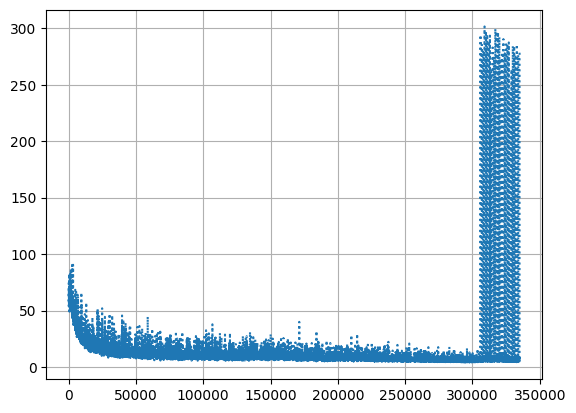

In [7]:
import matplotlib.pyplot as plt

losses = []

with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        losses.append(float(row[3]))

plt.plot(losses, label="Loss over training step", linestyle='dotted')
plt.grid()

## Model training

Now we want a phoneme recognition.
It means to train the last layer of the model to the ground truth.

In [ ]:
import csv
import os
import re


class PhonemeRecognizer(nn.Module):
    def __init__(self, wavlm_model, num_phonemes=NUM_PHONEMES):
        super().__init__()
        self.wavlm = wavlm_model

        # Get the hidden size from the WavLM model
        hidden_size = self.wavlm.config.hidden_size

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank), adds a new input for language
        self.phoneme_classifier = nn.Linear(1 + hidden_size, num_phonemes)

    def forward(self, inputs):
        # Get WavLM embeddings
        outputs = self.wavlm(input_values=inputs["input_values"], attention_mask=inputs["attention_mask"])
        hidden_states = outputs.last_hidden_state

        # Apply dropout
        hidden_states = self.dropout(hidden_states)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(torch.dstack([hidden_states, torch.ones(hidden_states.shape[1]) * inputs["language"]]))

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    seq.append(VOCAB[p])
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences


    def recognize(self, inputs):
        """Perform phoneme recognition."""
        self.eval()
        with torch.no_grad():
            # Forward pass to get log probabilities
            log_probs = self(inputs)

            return self.classify_to_phonemes(log_probs)

    def tokenize(self, char_list, lenient=False):
        """
        Go from a list of characters to a list of indices.
        
        :param list[str] char_list: Characters top be mapped.
        :param bool lenient: If True, characters not in vocab are mapped to [UNK] 
        """
        if not lenient:
            return torch.tensor([PHONEME_DICT[x] for x in char_list])
        
        return torch.tensor([PHONEME_DICT[x] if x in PHONEME_DICT else PHONEME_DICT["[UNK]"] for x in char_list])
    
    def get_embedding(self, char_list):
        tokens = self.tokenize(char_list)
        out_tensor = torch.zeros((len(tokens), len(VOCAB)))
        for i, token_id in enumerate(tokens):
            out_tensor[i, token_id] = 1
        return out_tensor

phoneme_recognizer = PhonemeRecognizer(wavlm_model)
phoneme_recognizer.train()
linear_optimizer = torch.optim.Adam(
    phoneme_recognizer.phoneme_classifier.parameters(),
    lr=1e-3,
    weight_decay=0
)


def calculate_ctc_loss(log_probs, target_sequence):
    """Calculates CTC loss."""
    # Create input_lengths and target_lengths tensors
    input_lengths = torch.tensor([1])  # Batch size of 1
    target_lengths = torch.tensor([1])  # Batch size of 1

    # Calculate CTC loss
    loss = F.ctc_loss(
        log_probs,
        target_sequence,
        input_lengths=input_lengths,
        target_lengths=target_lengths
    )
    return loss

MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"


def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(r"(\d+)\.pth$", x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(r"(\d+)\.pth$", checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            phoneme_recognizer.phoneme_classifier.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment

prepare_folders()
increment = load_last_checkpoint(MODEL_DIR)

# Freeze the wavlm model
for param in phoneme_recognizer.wavlm.parameters():
    param.requires_grad = False


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


# Training loop
for epoch in range(10):
    for i, data in enumerate(dataset.shuffle().select(range(50))):
        input_values = preprocess_audios(data)
        log_probs = phoneme_recognizer(input_values)
        split_phonemes = smart_split_coder(data["phoneme_sequence"][0])
        target = phoneme_recognizer.tokenize(split_phonemes)
        loss = calculate_ctc_loss(log_probs[0], target.reshape([1, -1]))
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        write_to_csv(
            [
                increment, epoch, i, loss.item(),
                "".join(phoneme_recognizer.classify_to_phonemes(log_probs)[0]),
                "".join(split_phonemes)
            ]
        )
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        increment += 1
        torch.save(
            phoneme_recognizer.phoneme_classifier.state_dict(),
            f"{MODEL_DIR}/phoneme_classifier_epoch_{epoch}_step_{i}_{increment}.pth"
        )
    

## Binary classification

We have a model roughly trained for phonemes.
We want a binary classification though.
We won't do that for now as it would be an end-to-end pipeline, defeating the purpose of the created pipeline.